<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#Определю-порог-классификации-для-LogisticRegression" data-toc-modified-id="Определю-порог-классификации-для-LogisticRegression-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Определю порог классификации для LogisticRegression</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li>

# Проект для «Викишоп»

Нужно обучить модель классифицировать комментарии на позитивные и негативные.

Построить модель со значением метрики качества *F1* не меньше 0.75.

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

In [ ]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Создам корпус слов и загружу библиотеки, необходимые для обработки текста:

In [ ]:
corpus = list(data['text'])
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Создам ф-ции для очистки данных и лемматизации слов:

In [ ]:
def clear_text(text):
    y=re.sub(r"[^'a-zA-Z ]", ' ', text)
    k=" ".join(y.split())
    return k

In [ ]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

Преобразую текст:

In [ ]:
def lemmafunction(textc):
    k=[]
    for i in nltk.word_tokenize(textc):
        y=lemmatizer.lemmatize(i, get_wordnet_pos(i))
        k.append(y)
    return ' '.join(k)

lemy=[]
for i in tqdm(range(len(corpus))):

    lemy.append(lemmafunction(clear_text(corpus[i])))
data['lemm_text']=pd.Series(lemy, index=data.index)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [ ]:
data['text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
data['lemm_text'][0]

"Explanation Why the edits make under my username Hardcore Metallica Fan be revert They be n't vandalism just closure on some GAs after I vote at New York Dolls FAC And please do n't remove the template from the talk page since I 'm retire now"

Проверю распределение классов:

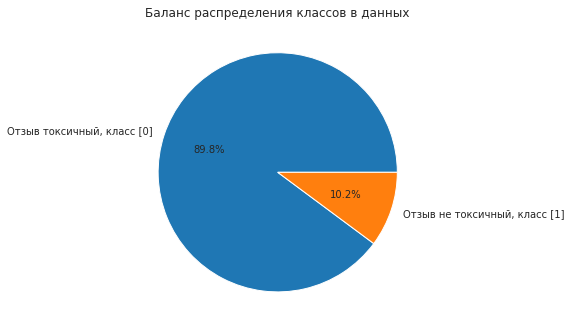

In [ ]:
sns.set_style('darkgrid')
data['toxic'].value_counts(normalize=True).plot(kind='pie',figsize=[5.5,5.5], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный, класс [0]','Отзыв не токсичный, класс [1]'])
plt.title('Баланс распределения классов в данных')
plt.ylabel('')
plt.show()

Виден значительный дисбаланс классов.

Разделю выборки:

In [ ]:
X = data.drop('toxic',axis=1)
y = data['toxic']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=666, shuffle=True, stratify=y)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=666, shuffle=True, stratify=y_test)

Создам функцию, чтобы сбалансировать классы:

In [ ]:
def down_up_sample(features, target, fraction, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_down_up = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]*repeat)
    target_down_up = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]*repeat)

    features_down_up_sampled, target_down_up_sampled = shuffle(
        features_down_up, target_down_up, random_state=12345)

    return features_down_up_sampled, target_down_up_sampled

features_upsampled, target_upsampled  = down_up_sample(X_train, y_train, 0.6, 5)

Проверю распределение:

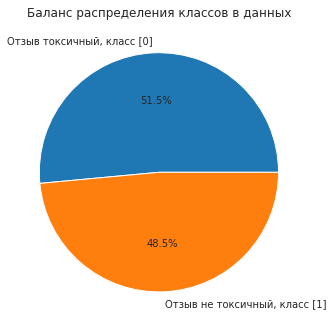

In [ ]:
target_upsampled.value_counts(normalize=True).plot(kind='pie',figsize=[5.5,5.5], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный, класс [0]','Отзыв не токсичный, класс [1]'])
plt.title('Баланс распределения классов в данных')
plt.ylabel('')
plt.show()

Обработаю данные при помощи TF-IDF:

In [ ]:
nltk.download('stopwords')
stop_words = list(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
corpus_lemm_train = features_upsampled['lemm_text'].values
corpus_lemm_train.shape

(100078,)

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words,analyzer='word')
tf_idf = count_tf_idf.fit_transform(corpus_lemm_train)
tf_idf.shape

(100078, 89282)

In [ ]:
corpus_lemm_val = X_val['lemm_text'].values
corpus_lemm_val.shape

(31859,)

In [ ]:
tf_val = count_tf_idf.transform(corpus_lemm_val)
tf_val.shape

(31859, 89282)

**Вывод:**
* Данные чистые, без пропусков
* Был дисбаланс классов, от которого я избавился
* Разбил датасет на выборки и подготовил данные к обучению

## Обучение

Плотность распределения:

In [ ]:
def graph_analis(true, predict):
    f1 = f1_score(y_val, predict)
    plt.figure(figsize=(10,6))
    true.plot(kind='kde', linewidth=2)
    pd.Series(predict).plot(kind='kde',linewidth=2)
    plt.title('График распределения плотности предсказанных и истинных значений', y=1.01)
    plt.legend(['Истинные значения','Предсказанные значения'])
    plt.text(0.75,6,'F1= {:.2f}'.format(f1))
    plt.xlabel('')
    plt.ylabel('Плотность')
    plt.show()

Матрица предсказаний:

In [ ]:
def highlight_min(data, color='red'):
    attr = 'color: {}'.format(color)
    if data.ndim == 1:
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [ ]:
def create_colors(x):
    df1 = x.copy()
    df1.loc[:,:] = 'background-color: '
    df1.loc['Predicted Positive(1)', 'Actually Negative(0)'] = 'background-color: coral'
    df1.loc['Predicted Negative(0)', 'Actually Positive(1)'] = 'background-color: coral'
    df1.loc['Predicted Positive(1)', 'Actually Positive(1)'] = 'background-color: springgreen'
    df1.loc['Predicted Negative(0)','Actually Negative(0)'] = 'background-color: springgreen'

    return df1

In [ ]:
def conf_marix(predict):
    table=pd.DataFrame(index=['Predicted Positive(1)','Predicted Negative(0)',], columns=['Actually Positive(1)','Actually Negative(0)','Difference'])
    matrix=confusion_matrix(y_val, predict)
    table['Actually Positive(1)']['Predicted Positive(1)']= 'TP  {:.0f}'.format(matrix[0][0])
    table['Actually Positive(1)']['Predicted Negative(0)']= 'FN   {:.0f}'.format(matrix[1][0])

    table['Actually Negative(0)']['Predicted Positive(1)']= 'FP  {:.0f}'.format(matrix[0][1])
    table['Actually Negative(0)']['Predicted Negative(0)']= 'TN  {:.0f}'.format(matrix[1][1])

    table['Difference'][0] = abs(matrix[0][0] - matrix[0][1])
    table['Difference'][1] = abs(matrix[1][1]- matrix[1][0])
    return table.style.apply(create_colors, axis=None).apply(highlight_min, subset=['Difference'])

### DecisionTreeClassifier

In [ ]:
best_model_dt = None
best_result_dt = 0
best_depth_dt=0
for depth in tqdm(range(1, 25, 3)):

    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth,class_weight='balanced')
    model_dt.fit(tf_idf, target_upsampled)

    predict_dt = model_dt.predict(tf_val)
    result_dt = f1_score(y_val, predict_dt)

    if result_dt > best_result_dt:
        best_model_dt = model_dt
        best_result_dt = result_dt

        best_depth_dt = depth
print("F1 наилучшей модели равно:", best_result_dt.round(2), end='')
print(' C глубиной:',best_depth_dt)

  0%|          | 0/8 [00:00<?, ?it/s]

F1 наилучшей модели равно: 0.6 C глубиной: 22


**Разеделил данные как 3:1:1, теперь обучаю на трейне, проверяю результаты на валидационной.**

In [ ]:
target_names = ['Отзыв токсичный','Отзыв не токсичный']

model_dt = DecisionTreeClassifier(random_state=12345, max_depth=best_depth_dt)
model_dt.fit(tf_idf, target_upsampled)
predicted_dt = model_dt.predict(tf_val)

f1_forest_1 = f1_score(y_val, predicted_dt)
print(classification_report(y_val, predicted_dt, target_names=target_names))
print('Метрика F1 качества предсказания модели "DecisionTreeClassifier" равна :',f1_forest_1.round(2))

                    precision    recall  f1-score   support

   Отзыв токсичный       0.95      0.97      0.96     28622
Отзыв не токсичный       0.68      0.53      0.60      3237

          accuracy                           0.93     31859
         macro avg       0.81      0.75      0.78     31859
      weighted avg       0.92      0.93      0.92     31859

Метрика F1 качества предсказания модели "DecisionTreeClassifier" равна : 0.6


In [ ]:
conf_marix(predicted_dt)

,Actually Positive(1),Actually Negative(0),Difference
Predicted Positive(1),TP 27813,FP 809,27004
Predicted Negative(0),FN 1508,TN 1729,221


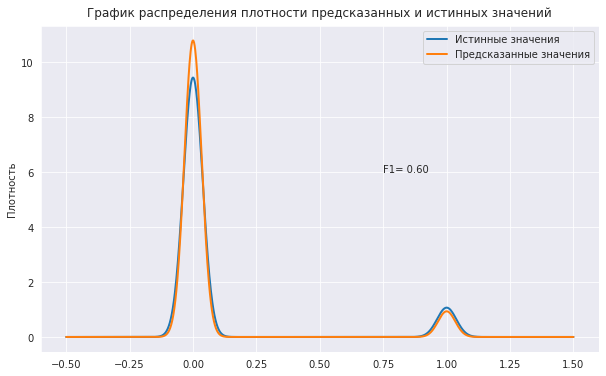

In [ ]:
graph_analis(y_val, predicted_dt)

### LogisticRegression

In [ ]:
clf_lr = LogisticRegression(random_state=12345, solver='sag', class_weight='balanced')
parametrs_lr = { 'C': range (1, 10),
              'max_iter': range (10,15,2),
              }
grid_lr = GridSearchCV(clf_lr, parametrs_lr, cv=3, scoring='f1')
grid_lr.fit(tf_idf, target_upsampled)
grid_lr.best_params_

{'C': 9, 'max_iter': 14}

In [ ]:
predicted_lr = grid_lr.predict(tf_val)

f1_log_r_1 = f1_score(y_val, predicted_lr).round(2)
print(classification_report(y_val, predicted_lr, target_names=target_names))
print('Метрика F1 качества предсказания модели "LogisticRegression" равна :',f1_log_r_1)

                    precision    recall  f1-score   support

   Отзыв токсичный       0.98      0.96      0.97     28622
Отзыв не токсичный       0.69      0.81      0.74      3237

          accuracy                           0.94     31859
         macro avg       0.83      0.89      0.86     31859
      weighted avg       0.95      0.94      0.95     31859

Метрика F1 качества предсказания модели "LogisticRegression" равна : 0.74


In [ ]:
conf_marix(predicted_lr)

,Actually Positive(1),Actually Negative(0),Difference
Predicted Positive(1),TP 27411,FP 1211,26200
Predicted Negative(0),FN 601,TN 2636,2035


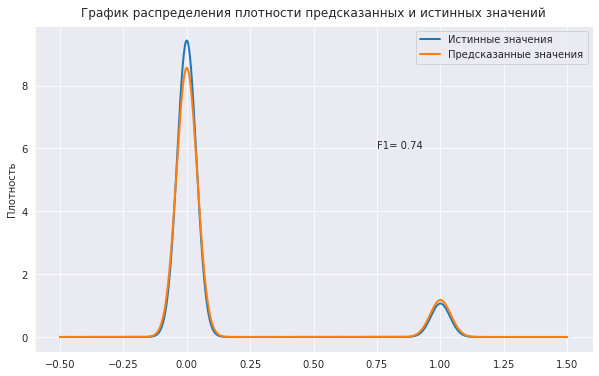

In [ ]:
graph_analis(y_val, predicted_lr)

### RandomForestClassifier

In [ ]:
best_model_rf = None
best_result_rf = 0
best_depth_rf = 0

for est in tqdm(range(1, 12, 4)):

    model_rf = RandomForestClassifier(random_state=12345, n_estimators=est,class_weight='balanced_subsample')
    model_rf.fit(tf_idf, target_upsampled)
    predict_rf=model_rf.predict(tf_val)
    result_rf = f1_score(y_val, predict_rf)

    if result_rf > best_result_rf:
        best_model_rf = model_rf
        best_result_rf = result_rf

        best_depth_rf = est

print("F1 наилучшей модели равно:", best_result_rf.round(2), end='')
print(' C глубиной:', best_depth_rf)

  0%|          | 0/3 [00:00<?, ?it/s]

F1 наилучшей модели равно: 0.66 C глубиной: 9


In [ ]:
predict_rfc=model_rf.predict(tf_val)
f1_random_forest = f1_score(y_val, predict_rfc)
print(classification_report(y_val, predict_rfc, target_names=target_names))
print('Метрика F1 качества предсказания модели "RandomForestClassifier" равна :',f1_random_forest.round(2))

                    precision    recall  f1-score   support

   Отзыв токсичный       0.96      0.98      0.97     28622
Отзыв не токсичный       0.74      0.60      0.66      3237

          accuracy                           0.94     31859
         macro avg       0.85      0.79      0.81     31859
      weighted avg       0.93      0.94      0.93     31859

Метрика F1 качества предсказания модели "RandomForestClassifier" равна : 0.66


In [ ]:
conf_marix(predict_rfc)

,Actually Positive(1),Actually Negative(0),Difference
Predicted Positive(1),TP 27920,FP 702,27218
Predicted Negative(0),FN 1288,TN 1949,661


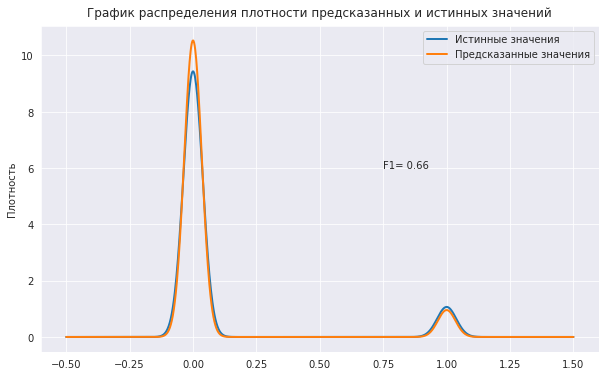

In [ ]:
graph_analis(y_val, predict_rfc)

### Определю порог классификации для LogisticRegression

In [ ]:
probabilities = grid_lr.predict_proba(tf_val)
probabilities_one = probabilities[:, 1]
print("Вероятность положительного класса:", probabilities_one[:5])

Вероятность положительного класса: [0.00098746 0.02920463 0.04229655 0.04435966 0.01505182]


In [ ]:
for threshold in np.arange(0.4, 0.9, 0.02):
    predicted_v = probabilities_one > threshold
    precision = precision_score(y_val, predicted_v)
    recall = recall_score(y_val, predicted_v)
    f1 = f1_score(y_val, predicted_v)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.40 | Точность = 0.630, Полнота = 0.840, F1 = 0.720
Порог = 0.42 | Точность = 0.641, Полнота = 0.835, F1 = 0.725
Порог = 0.44 | Точность = 0.651, Полнота = 0.829, F1 = 0.730
Порог = 0.46 | Точность = 0.663, Полнота = 0.825, F1 = 0.735
Порог = 0.48 | Точность = 0.675, Полнота = 0.820, F1 = 0.740
Порог = 0.50 | Точность = 0.685, Полнота = 0.814, F1 = 0.744
Порог = 0.52 | Точность = 0.694, Полнота = 0.808, F1 = 0.747
Порог = 0.54 | Точность = 0.700, Полнота = 0.800, F1 = 0.747
Порог = 0.56 | Точность = 0.711, Полнота = 0.796, F1 = 0.751
Порог = 0.58 | Точность = 0.719, Полнота = 0.788, F1 = 0.752
Порог = 0.60 | Точность = 0.728, Полнота = 0.778, F1 = 0.752
Порог = 0.62 | Точность = 0.737, Полнота = 0.772, F1 = 0.754
Порог = 0.64 | Точность = 0.750, Полнота = 0.768, F1 = 0.759
Порог = 0.66 | Точность = 0.759, Полнота = 0.762, F1 = 0.760
Порог = 0.68 | Точность = 0.769, Полнота = 0.756, F1 = 0.762
Порог = 0.70 | Точность = 0.777, Полнота = 0.749, F1 = 0.763
Порог = 0.72 | Точность 

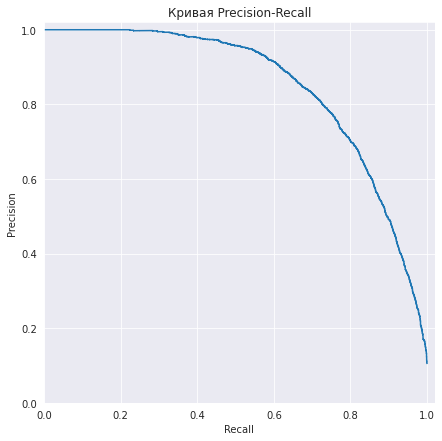

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_val, probabilities[:, 1])
plt.figure(figsize=(7, 7))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.02])
plt.xlim([0.0, 1.02])
plt.title('Кривая Precision-Recall')
plt.show()

In [ ]:
predicted_rf_threshold = (probabilities_one>0.76)*1
print(classification_report(y_val, predicted_rf_threshold, target_names=target_names))

                    precision    recall  f1-score   support

   Отзыв токсичный       0.97      0.98      0.97     28622
Отзыв не токсичный       0.81      0.72      0.76      3237

          accuracy                           0.95     31859
         macro avg       0.89      0.85      0.87     31859
      weighted avg       0.95      0.95      0.95     31859



Проверю выбранный порог:

In [ ]:
corpus_lemm_test = X_test['lemm_text'].values
corpus_lemm_test.shape

(31858,)

In [ ]:
tf_test = count_tf_idf.transform(corpus_lemm_test)
tf_test.shape

(31858, 89282)

In [ ]:
predicted_test = (grid_lr.predict_proba(tf_test)[:,1] > 0.76)*1
f1_log_r_1 = f1_score(y_test, predicted_test).round(2)
print('Метрика F1 качества предсказания наилучшей модели с порогом классификации 0,76 равна : ',f1_log_r_1)

Метрика F1 качества предсказания наилучшей модели с порогом классификации 0,76 равна :  0.76


In [ ]:
def conf_marix_test(predict):
    table=pd.DataFrame(index=['Predicted Positive(1)','Predicted Negative(0)',], columns=['Actually Positive(1)','Actually Negative(0)','Difference'])
    matrix=confusion_matrix(y_test, predict)
    table['Actually Positive(1)']['Predicted Positive(1)']= 'TP  {:.0f}'.format(matrix[0][0])
    table['Actually Positive(1)']['Predicted Negative(0)']= 'FN   {:.0f}'.format(matrix[1][0])

    table['Actually Negative(0)']['Predicted Positive(1)']= 'FP  {:.0f}'.format(matrix[0][1])
    table['Actually Negative(0)']['Predicted Negative(0)']= 'TN  {:.0f}'.format(matrix[1][1])

    table['Difference'][0] = abs(matrix[0][0] - matrix[0][1])
    table['Difference'][1] = abs(matrix[1][1]- matrix[1][0])
    return table.style.apply(create_colors, axis=None).apply(highlight_min, subset=['Difference'])

In [ ]:
conf_marix_test(predicted_test)

,Actually Positive(1),Actually Negative(0),Difference
Predicted Positive(1),TP 28015,FP 606,27409
Predicted Negative(0),FN 883,TN 2354,1471


In [ ]:
def graph_analis_test(true, predict):
    f1 = f1_score(y_test, predict)
    plt.figure(figsize=(10,6))
    true.plot(kind='kde', linewidth=2)
    pd.Series(predict).plot(kind='kde',linewidth=2)
    plt.title('График распределения плотности предсказанных и истинных значений', y=1.01)
    plt.legend(['Истинные значения','Предсказанные значения'])
    plt.text(0.75,6,'F1= {:.2f}'.format(f1))
    plt.xlabel('')
    plt.ylabel('Плотность')
    plt.show()

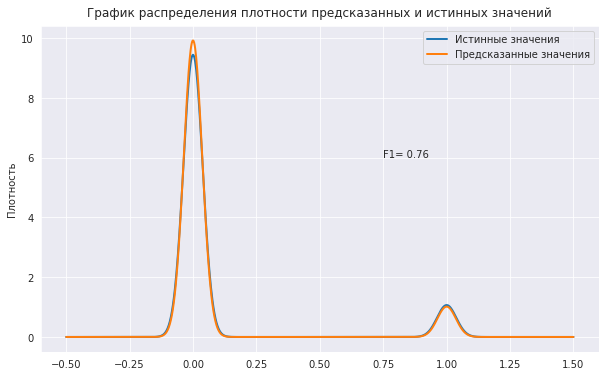

In [ ]:
graph_analis_test(y_test, predicted_test)

Вычислю ROC-AUC для наилучшей модели

In [ ]:
probabilities_test = grid_lr.predict_proba(tf_test)
probabilities_one_test = probabilities_test[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('ROC-AUC: {:.2f}'.format(auc_roc))

ROC-AUC: 0.96


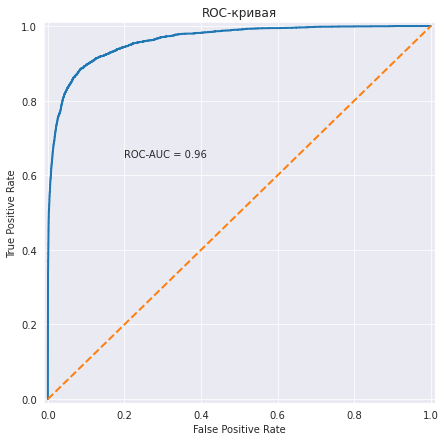

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr,linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.text(0.2,0.65,'ROC-AUC = {:.2f}'.format(auc_roc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Выводы

In [ ]:
comparison_tabl = pd.DataFrame(index=['F1-мера'], columns=['Дерево решений','Cлучайный лес','Логистическая регрессия'])
comparison_tabl['Дерево решений'] = best_result_dt.round(2)
comparison_tabl['Cлучайный лес'] = f1_random_forest.round(2)
comparison_tabl['Логистическая регрессия'] = f1_log_r_1
comparison_tabl.T

,F1-мера
Дерево решений,0.60
Cлучайный лес,0.66
Логистическая регрессия,0.76


Модель логистической регресси удовлетворяет требованию задания — F1 > 0.75

**Вывод**

В ходе проекта, чтобы добиться оптимального результата, я:
* Очистил комментарии от лишних символов
* Сбалансировал классы комментариев
* Обучил три модели

Модель логистической регрессии показала наилучший результат